Method and tests from paper: 

@article{iooss2017shapley,
  title={Shapley effects for sensitivity analysis with dependent inputs: comparisons with Sobol’indices, numerical estimation and applications},
  author={Iooss, Bertrand and Prieur, Cl{\'e}mentine},
  journal={arXiv preprint arXiv:1707.01334},
  year={2017}
}

In [1]:
from SALib.sample.shapley import sample
from SALib.analyze.shapley import analyze

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

def get_sensitivity_stats(problem, si_fabric, n=100, plotting=False):
    results = {}
    for _ in tqdm(range(n)):
        Sis = si_fabric(problem)
        for k, v in Sis.items():
            if k not in results:
                results[k] = [v]
            else:
                results[k].append(v)
                
    for k in results:
        results[k] = np.array(results[k])
    
    if plotting:
        for k in results:
            for i in range(problem['num_vars']):
                print("===========")
                print(k, problem['names'][i])
                print('median: ', np.median(results[k][:, i]))
                print('mean: ', np.mean(results[k][:, i]))
                print('std: ', np.std(results[k][:, i]))
                plt.title(k)
                sns.distplot(results[k][:, i])
                plt.show()
                plt.close()
    
    return results 

In [ ]:
def make_Sh(problem):
    analyze_args = {
        'n_perms': None,
        'n_var': 100, # unstable if small
        'n_outer': 100,
        'n_inner': 100,
    }

    sample_args = {
        **analyze_args,
        'randomize': True
    }
    
    x = sample(problem, **sample_args)
    y = problem['func'](x)
    return analyze(problem, x, y, **analyze_args)

# First test

In [13]:
def make_problem1(rho):
    betta = np.array([1.0, 1.0])
    mu = np.array([0.0, 0.0])
    sigma = np.array([1.0, 2.0])

    def func(v):
        return v.dot(np.expand_dims(betta, axis=1))

    def si_analytical(rho):
        sigma2 = betta[0]**2*sigma[0]**2+2*rho*betta[0]*betta[1]*sigma[0]*sigma[1]+betta[1]**2*sigma[1]**2
        Sh1 = (betta[0]**2*sigma[0]**2*(1-rho**2/2)+rho*betta[0]*betta[1]*sigma[0]*sigma[1]+betta[1]**2*sigma[1]**2*rho**2/2)/sigma2
        Sh2 = (betta[1]**2*sigma[1]**2*(1-rho**2/2)+rho*betta[0]*betta[1]*sigma[0]*sigma[1]+betta[0]**2*sigma[0]**2*rho**2/2)/sigma2
        S11 = (betta[0]**2*sigma[0]**2+2*rho*betta[0]*betta[1]*sigma[0]*sigma[1]+rho**2*betta[1]**2*sigma[1]**2)/sigma2
        S12 = (betta[1]**2*sigma[1]**2+2*rho*betta[0]*betta[1]*sigma[0]*sigma[1]+rho**2*betta[0]**2*sigma[0]**2)/sigma2
        ST1 = betta[0]**2*sigma[0]**2*(1-rho**2)/sigma2
        ST2 = betta[1]**2*sigma[1]**2*(1-rho**2)/sigma2

        return {
            'S1': [S11, S12],
            'ST': [ST1, ST2],
            'Sh': [Sh1, Sh2],
        }


    problem = {
        'num_vars': 2,
        'names': ['x1', 'x2'],
        'distrs': ['norm', 'norm'],
        'bounds': [
            [mu[0], sigma[0]],
            [mu[1], sigma[1]],
        ],
        'corr': [
            [1, rho],
            [rho, 1]
        ],
        'func': func,
        'analytical': si_analytical,
    }
    
    return problem

## Single rho test

In [15]:
rho=0.5
problem = make_problem1(rho)
results = get_sensitivity_stats(problem, make_Sh, n=100, plotting=False)

100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


In [16]:
print('S1', results['S1'].mean(axis=0))
print('ST', results['ST'].mean(axis=0))
print('Sh', results['Sh'].mean(axis=0))
problem['analytical'](rho)

S1 [0.57559842 0.89369998]
ST [0.10630002 0.42440158]
Sh [0.34094922 0.65905078]


{'S1': [0.5714285714285714, 0.8928571428571429],
 'ST': [0.10714285714285714, 0.42857142857142855],
 'Sh': [0.3392857142857143, 0.6607142857142857]}

## Plot sensitivity dependency(rho) for first test

In [18]:
sis = []
rhos = np.linspace(-0.9, 0.9, 20)

for rho in rhos:
    problem = make_problem1(rho)
    results = get_sensitivity_stats(problem, make_Sh, n=100, plotting=False)
    si_a = problem['analytical'](rho)
    sis.append({
        'rho': rho,
        'S1_c': results['S1'].mean(axis=0),
        'ST_c': results['ST'].mean(axis=0),
        'Sh_c': results['Sh'].mean(axis=0),
        'S1_a': si_a['S1'],
        'ST_a': si_a['ST'],
        'Sh_a': si_a['Sh'],
    })

100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


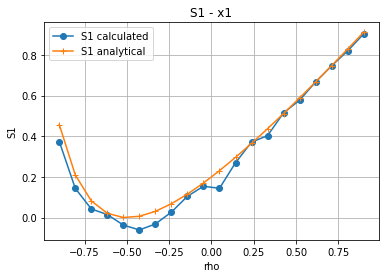

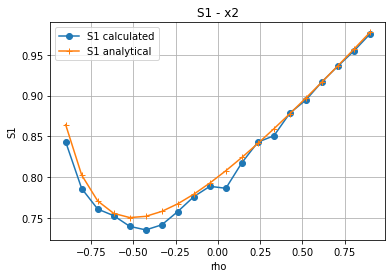

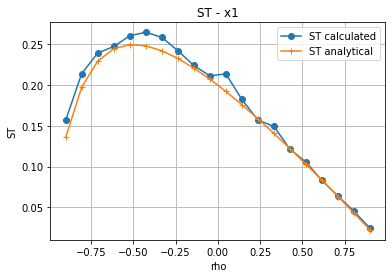

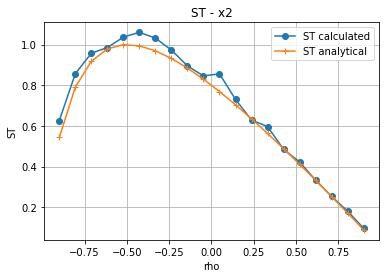

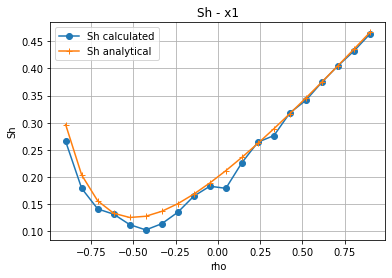

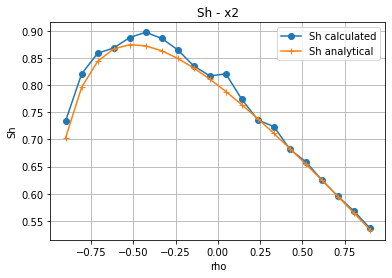

In [29]:
for si in ['S1', 'ST', 'Sh']:
    si_c = np.array([p[f'{si}_c'] for p in sis])
    si_a = np.array([p[f'{si}_a'] for p in sis])
    for i in range(si_c[0].shape[0]):
        plt.plot(rhos, si_c[:, i], label=f'{si} calculated', marker='o')
        plt.plot(rhos, si_a[:, i], label=f'{si} analytical', marker='+')
        plt.xlabel('rho')
        plt.ylabel(si)
        plt.title(f'{si} - x{i+1}')
        plt.legend()
        plt.grid()
        plt.show()
        plt.close()

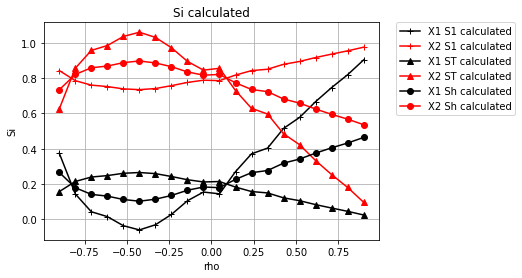

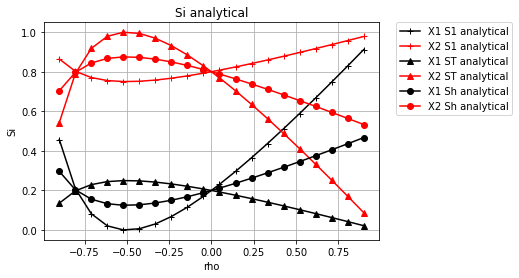

In [34]:
colors = {
    0: 'black',
    1: 'red'
}

for m in ['c', 'a']:
    method = "calculated" if m =="c" else "analytical"
    for si, marker in [['S1', '+'], ['ST', '^'], ['Sh', 'o']]:
        for i in range(si_c[0].shape[0]):
            numbers = np.array([p[f'{si}_{m}'] for p in sis])[:, i]
            plt.plot(rhos, numbers, label=f'X{i+1} {si} {method}', marker=marker, color=colors[i])
    
    plt.xlabel('rho')
    plt.ylabel('Si')
    plt.title(f'Si {method}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()
    plt.show()
    plt.close()

# Second Test

In [38]:
def make_problem2(rho):
    betta = np.array([1.0, 1.0, 1.0])
    mu = np.array([0.0, 0.0, 0.0])
    sigma = np.array([1.0, 1.0, 2.0])

    def func(v):
        return v.dot(np.expand_dims(betta, axis=1))

    def si_analytical(rho):
        sigma2 = sum([betta[j]**2*sigma[j]**2 for j in range(3)])+2*rho*betta[1]*betta[2]*sigma[1]*sigma[2]
        Sh1 = betta[0]**2*sigma[0]**2/sigma2
        Sh2 = (betta[1]**2*sigma[1]**2+rho*betta[1]*betta[2]*sigma[1]*sigma[2]+rho**2/2*(betta[2]**2*sigma[2]**2-betta[1]**2*sigma[1]**2))/sigma2
        Sh3 = (betta[2]**2*sigma[2]**2+rho*betta[1]*betta[2]*sigma[1]*sigma[2]+rho**2/2*(betta[1]**2*sigma[1]**2-betta[2]**2*sigma[2]**2))/sigma2
        
        # only for these betta and sigma
        S11 = 1/(2+sigma2+2*rho*sigma2**0.5)
        S12 = (1+rho*sigma2**0.5)**2/(2+sigma2+2*rho*sigma2**0.5)
        S13 = (rho+sigma2**0.5)**2/(2+sigma2+2*rho*sigma2**0.5)
        ST1 = 1/(2+sigma2+2*rho*sigma2**0.5)
        ST2 = (1-rho**2)/(2+sigma2+2*rho*sigma2**0.5)
        ST3 = sigma2*(1-rho**2)/(2+sigma2+2*rho*sigma2**0.5)
        
        return {
            'S1': [S11, S12, S13],
            'ST': [ST1, ST2, ST3],
            'Sh': [Sh1, Sh2, Sh3],
        }


    problem = {
        'num_vars': 3,
        'names': ['x1', 'x2', 'x3'],
        'distrs': ['norm', 'norm', 'norm'],
        'bounds': [
            [mu[0], sigma[0]],
            [mu[1], sigma[1]],
            [mu[2], sigma[2]],
        ],
        'corr': [
            [1, 0.0, 0.0],
            [0.0, 1.0, rho],
            [0.0, rho, 1.0],
        ],
        'func': func,
        'analytical': si_analytical,
    }
    
    return problem

## Single rho test

In [36]:
rho=0.5
problem = make_problem2(rho)
results = get_sensitivity_stats(problem, make_Sh, n=100, plotting=False)

100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


In [40]:
print('S1', results['S1'].mean(axis=0))
print('ST', results['ST'].mean(axis=0))
print('Sh', results['Sh'].mean(axis=0))
problem['analytical'](rho)

S1 [0.10621363 0.47614601 0.77234125]
ST [0.12898077 0.09885759 0.39544305]
Sh [0.12124126 0.29136271 0.58739602]


{'S1': [0.07795187907884576, 0.45433684644807965, 0.86358421161202],
 'ST': [0.07795187907884576, 0.058463909309134324, 0.4677112744730746],
 'Sh': [0.125, 0.296875, 0.578125]}

## Plot sensitivity dependency(rho) for first test

In [41]:
sis = []
rhos = np.linspace(-0.9, 0.9, 20)

for rho in rhos:
    problem = make_problem2(rho)
    results = get_sensitivity_stats(problem, make_Sh, n=100, plotting=False)
    si_a = problem['analytical'](rho)
    sis.append({
        'rho': rho,
        'S1_c': results['S1'].mean(axis=0),
        'ST_c': results['ST'].mean(axis=0),
        'Sh_c': results['Sh'].mean(axis=0),
        'S1_a': si_a['S1'],
        'ST_a': si_a['ST'],
        'Sh_a': si_a['Sh'],
    })

100%|██████████| 100/100 [02:07<00:00,  1.28s/it]


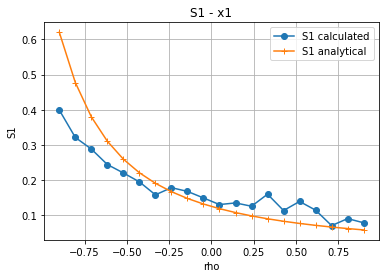

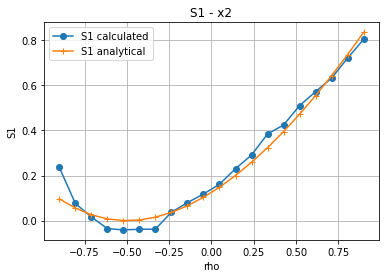

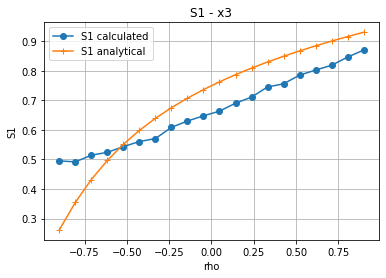

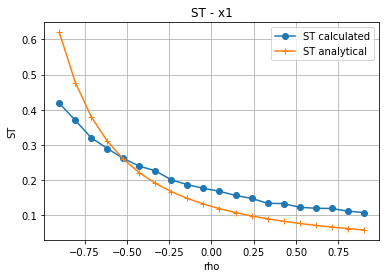

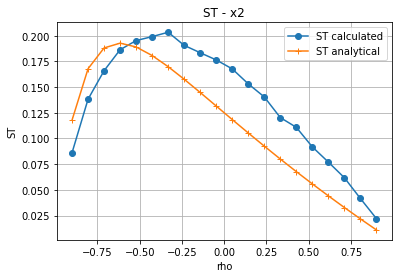

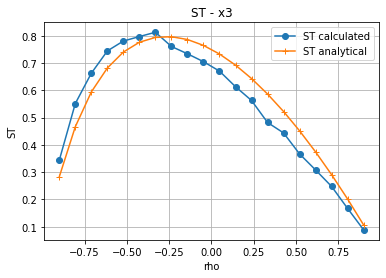

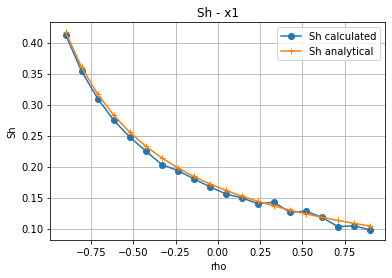

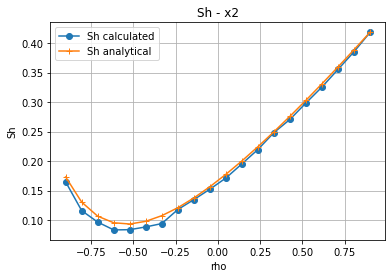

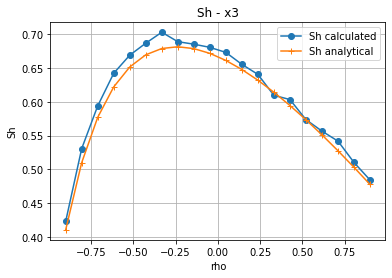

In [42]:
for si in ['S1', 'ST', 'Sh']:
    si_c = np.array([p[f'{si}_c'] for p in sis])
    si_a = np.array([p[f'{si}_a'] for p in sis])
    for i in range(si_c[0].shape[0]):
        plt.plot(rhos, si_c[:, i], label=f'{si} calculated', marker='o')
        plt.plot(rhos, si_a[:, i], label=f'{si} analytical', marker='+')
        plt.xlabel('rho')
        plt.ylabel(si)
        plt.title(f'{si} - x{i+1}')
        plt.legend()
        plt.grid()
        plt.show()
        plt.close()

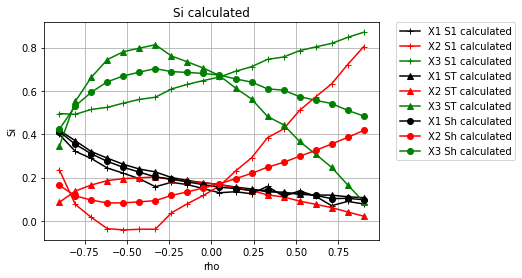

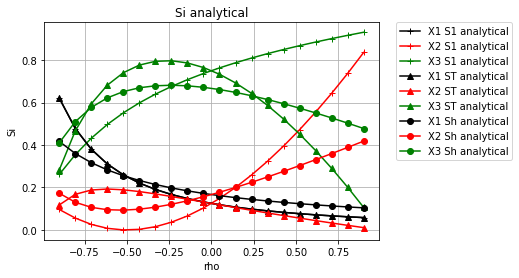

In [43]:
colors = {
    0: 'black',
    1: 'red',
    2: 'green'
}

for m in ['c', 'a']:
    method = "calculated" if m =="c" else "analytical"
    for si, marker in [['S1', '+'], ['ST', '^'], ['Sh', 'o']]:
        for i in range(si_c[0].shape[0]):
            numbers = np.array([p[f'{si}_{m}'] for p in sis])[:, i]
            plt.plot(rhos, numbers, label=f'X{i+1} {si} {method}', marker=marker, color=colors[i])
    
    plt.xlabel('rho')
    plt.ylabel('Si')
    plt.title(f'Si {method}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.grid()
    plt.show()
    plt.close()